# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [130]:
#!pip install xgboost

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import time

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


# magic word for producing visualizations in notebook
%matplotlib inline

#Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Load all the data

In [56]:
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

customers = pd.read_csv('customers.csv')
azdias    = pd.read_csv('azdias.csv')
features  = pd.read_excel('DIAS Attributes - Values 2017.xlsx' , sheet_name = 'Tabelle1' ,index = False)
train     = pd.read_csv('mailout_train.csv')
test      = pd.read_csv('mailout_test.csv')

### Check Feature dataset to understand unknown data

In [4]:
features[features['Meaning'] == 'unknown' ]

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


# Part 0 :: Performing EDA on all 4 datasets

#### Creating snippets of functions which will be applied on all 4 datasets 

In [ ]:
def filling_nan(df):
    df_1 = df.replace( (-1,0) , np.nan)
    return df_1

    
There are few rows where 9 is treated as unknown but due to lack of time . I am leaving this .

In [6]:
def total_missing_values(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
    

In [7]:
def column_type(df):
    numerical_feats = df.dtypes[df.dtypes != "object"].index
    print("Number of Numerical features: ", len(numerical_feats))

    categorical_feats = df.dtypes[df.dtypes == "object"].index
    print("Number of Categorical features: ", len(categorical_feats))
    
    return numerical_feats ,categorical_feats

In [25]:
#Imputation Logic :: Categorical columns -> Mode , Numerical variables -> Median
def impute_nan(df , categorical_feats , numerical_feats):
    for col in categorical_feats:
        df[col].fillna(df[col].mode()[0], inplace=True)

    for i in numerical_feats:
        df[i].fillna(df[i].median(), inplace=True)
     
    return df

#imputer_categorical_feats = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
#imputer_numerical_feats   = Imputer(missing_values='NaN',strategy='median',axis=0)

In [36]:
def scale(df ,numerical_feats ):
    scaler_num = MinMaxScaler()
    df[numerical_feats] = scaler_num.fit_transform(df[numerical_feats])
       
    return df  

In [10]:
def encode(df):
    for i in categorical_feats:  
        label_encoder = LabelEncoder()
        #df[i]= label_encoder.fit_transform(df[i]) 
        df[categorical_feats].apply(LabelEncoder().fit_transform)
    return df

# 1) Customer Dataset

In [178]:
customers_1 = filling_nan(customers)
customers_1.head(6)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,NaN,1,4
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,9.0,NaN,3,FOOD,SINGLE_BUYER,NaN,1,4
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,NaN,2,4
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,NaN,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,NaN,1,4
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,NaN,1,3
5,143888,1.0,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,NaN,1,3


In [179]:
customers_missing_values = total_missing_values(customers_1)

In [180]:
customers_missing_values[customers_missing_values['Percent'] > 30]

,Total,Percent
D19_TELKO_ONLINE_QUOTE_12,191454,99.896688
ALTER_KIND4,191416,99.876860
D19_VERSI_ONLINE_QUOTE_12,191394,99.865381
ALTER_KIND3,190377,99.334732
SOHO_KZ,190221,99.253334
...,...,...
VHN,60064,31.340137
KKK,60064,31.340137
KBA05_HERST4,59303,30.943063
KBA05_ALTER4,58415,30.479724


In [181]:
customers_missing_more_than_30pc = list(customers_missing_values[customers_missing_values['Percent'] > 30].index.values)
customers_missing_more_than_30pc

['D19_TELKO_ONLINE_QUOTE_12',
 'ALTER_KIND4',
 'D19_VERSI_ONLINE_QUOTE_12',
 'ALTER_KIND3',
 'SOHO_KZ',
 'TITEL_KZ',
 'ANZ_TITEL',
 'D19_BANKEN_LOKAL',
 'ALTER_KIND2',
 'ANZ_HH_TITEL',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_TELKO_ANZ_12',
 'D19_TIERARTIKEL',
 'D19_DIGIT_SERV',
 'D19_BANKEN_ANZ_12',
 'D19_GARTEN',
 'ALTER_KIND1',
 'UNGLEICHENN_FLAG',
 'ANZ_KINDER',
 'D19_TELKO_ANZ_24',
 'KBA05_ANTG4',
 'D19_VERSI_ANZ_12',
 'D19_BANKEN_REST',
 'D19_BANKEN_GROSS',
 'D19_BIO_OEKO',
 'ONLINE_PURCHASE',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_BANKEN_ANZ_24',
 'D19_ENERGIE',
 'HH_DELTA_FLAG',
 'D19_LEBENSMITTEL',
 'D19_VERSI_ANZ_24',
 'D19_TELKO_REST',
 'KBA05_ANTG3',
 'KBA05_SEG6',
 'D19_BANKEN_DIREKT',
 'KONSUMZELLE',
 'D19_WEIN_FEINKOST',
 'D19_FREIZEIT',
 'D19_SCHUHE',
 'D19_RATGEBER',
 'D19_VERSAND_REST',
 'D19_DROGERIEARTIKEL',
 'D19_TELKO_MOBILE',
 'D19_BILDUNG',
 'D19_BEKLEIDUNG_GEH',
 'D19_KINDERARTIKEL',
 'D19_SAMMELARTIKEL',
 'D19_VERSICHERUNGEN',
 'D19_HANDWERK',
 'D19_VERSAND_ONLINE_QUOTE

In [185]:
### Dropping all columns which has more than 30% missing values. Total of 134 columns have been removed 
customers_after_dropping_cols = customers_1.drop(customers_missing_more_than_30pc , axis = 1)
customers_after_dropping_cols

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,1.0,2.0,1.0,1.0,3.0,1A,1,13,...,3.0,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,1,4
1,9628,9.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,3.0,NaN,9.0,NaN,3,FOOD,SINGLE_BUYER,1,4
2,143872,1.0,1.0,1.0,1.0,3.0,7.0,5D,5,34,...,13.0,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,2,4
3,143873,1.0,NaN,NaN,1.0,1.0,7.0,4C,4,24,...,4.0,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,1,4
4,143874,1.0,7.0,4.0,7.0,3.0,3.0,7B,7,41,...,5.0,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,154561,1.0,1.0,1.0,1.0,3.0,1.0,1C,1,14,...,8.0,5.0,6.0,9.0,1.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,1,3
191648,154563,2.0,NaN,NaN,1.0,1.0,6.0,5B,5,32,...,7.0,4.0,NaN,9.0,3.0,3,COSMETIC,SINGLE_BUYER,2,4
191649,148813,1.0,1.0,3.0,1.0,3.0,7.0,4D,4,24,...,8.0,5.0,3.0,9.0,3.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,1,4
191650,148852,1.0,4.0,4.0,3.0,3.0,3.0,4C,4,24,...,1.0,1.0,4.0,9.0,2.0,3,FOOD,SINGLE_BUYER,2,3


In [183]:
 customer_numerical_feats ,customer_categorical_feats = column_type(customers_after_dropping_cols)

Number of Numerical features:  227
Number of Categorical features:  8


In [186]:
# saving a copy 
customers_after_dropping_cols_copy = pd.DataFrame(customers_after_dropping_cols)

customers_after_imputation = impute_nan(customers_after_dropping_cols,customer_categorical_feats,customer_numerical_feats )
customers_after_imputation.head()


,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,1.0,2.0,1.0,1.0,3.0,1A,1,13,...,3.0,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,1,4
1,9628,9.0,1.0,3.0,1.0,3.0,5.0,2D,2,14,...,6.0,3.0,5.0,9.0,3.0,3,FOOD,SINGLE_BUYER,1,4
2,143872,1.0,1.0,1.0,1.0,3.0,7.0,5D,5,34,...,13.0,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,2,4
3,143873,1.0,1.0,2.0,1.0,1.0,7.0,4C,4,24,...,4.0,2.0,5.0,9.0,7.0,1,COSMETIC,MULTI_BUYER,1,4
4,143874,1.0,7.0,4.0,7.0,3.0,3.0,7B,7,41,...,5.0,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,1,3


In [187]:
customers_after_imputation.shape

(191652, 235)

### sanity check on customer data

In [188]:
check = total_missing_values(customers_after_imputation)
check

,Total,Percent
ALTERSKATEGORIE_GROB,0,0.0
KBA05_KW1,0,0.0
KBA05_SEG3,0,0.0
KBA05_SEG2,0,0.0
KBA05_MOTOR,0,0.0
...,...,...
KBA13_MAZDA,0,0.0
KBA13_KW_61_120,0,0.0
KBA13_KW_30,0,0.0
KBA13_KW_0_60,0,0.0


Missing Values have been removed.

In [191]:
#Checking categorical variables
customers_after_imputation[customer_categorical_feats].nunique()

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               3034
OST_WEST_KZ                    2
PRODUCT_GROUP                  3
CUSTOMER_GROUP                 2
dtype: int64

In [192]:
##Dropping 5 categorical features due to too much cardinality
drop_cols = ['CAMEO_DEU_2015','CAMEO_DEUG_2015','CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM']
customers_after_imputation.drop(drop_cols,axis = 1 , inplace=True)

In [193]:
#Encoding remaining categorical Features with label encoder.

le= preprocessing.LabelEncoder()
customers_after_imputation['OST_WEST_KZ']= le.fit_transform(customers_after_imputation['OST_WEST_KZ'])
customers_after_imputation['PRODUCT_GROUP'] =le.fit_transform(customers_after_imputation['PRODUCT_GROUP'])
customers_after_imputation['CUSTOMER_GROUP'] = le.fit_transform(customers_after_imputation['CUSTOMER_GROUP'])
customers_after_imputation.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,1.0,2.0,1.0,1.0,3.0,5.0,4.0,1.0,...,3.0,2.0,6.0,9.0,7.0,3,1,0,1,4
1,9628,9.0,1.0,3.0,1.0,3.0,5.0,4.0,5.0,2.0,...,6.0,3.0,5.0,9.0,3.0,3,2,1,1,4
2,143872,1.0,1.0,1.0,1.0,3.0,7.0,2.0,5.0,2.0,...,13.0,11.0,6.0,9.0,2.0,3,1,0,2,4
3,143873,1.0,1.0,2.0,1.0,1.0,7.0,2.0,5.0,1.0,...,4.0,2.0,5.0,9.0,7.0,1,0,0,1,4
4,143874,1.0,7.0,4.0,7.0,3.0,3.0,6.0,4.0,3.0,...,5.0,4.0,2.0,9.0,3.0,1,2,0,1,3


In [195]:
customers_after_scaling = scale(customers_after_imputation , customer_numerical_feats)
customers_after_scaling.head(7)

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.050221,0.0,0.000000,0.05,0.000000,0.000,0.333333,0.8,0.75,0.00,...,0.166667,0.1,1.0,1.0,0.857143,0.4,1,0,0.0,0.375
1,0.050232,1.0,0.000000,0.10,0.000000,0.250,0.666667,0.6,1.00,0.25,...,0.416667,0.2,0.8,1.0,0.285714,0.4,2,1,0.0,0.375
2,0.750693,0.0,0.000000,0.00,0.000000,0.250,1.000000,0.2,1.00,0.25,...,1.000000,1.0,1.0,1.0,0.142857,0.4,1,0,1.0,0.375
3,0.750698,0.0,0.000000,0.05,0.000000,0.000,1.000000,0.2,1.00,0.00,...,0.250000,0.1,0.8,1.0,0.857143,0.0,0,0,0.0,0.375
4,0.750703,0.0,0.011494,0.15,0.016043,0.250,0.333333,1.0,0.75,0.50,...,0.333333,0.3,0.2,1.0,0.285714,0.0,2,0,0.0,0.250
5,0.750776,0.0,0.000000,0.05,0.000000,0.250,1.000000,0.6,0.50,0.00,...,0.083333,0.0,1.0,1.0,0.000000,0.2,1,0,0.0,0.250
6,0.750860,0.0,0.000000,0.05,0.000000,0.125,0.833333,0.2,1.00,0.00,...,0.250000,0.1,1.0,1.0,0.857143,0.0,1,0,0.0,0.375


In [196]:
#customer_final = customers_after_scaling

### 2) azdias dataset

In [14]:
azdias_1 = filling_nan(azdias)
azdias_1.head(6)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,NaN,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


In [15]:
azdias_missing_values = total_missing_values(azdias_1)

In [16]:
azdias_missing_values[azdias_missing_values['Percent'] > 30]

,Total,Percent
D19_TELKO_ONLINE_QUOTE_12,890433,99.911582
ALTER_KIND4,890016,99.864792
D19_VERSI_ONLINE_QUOTE_12,889575,99.815310
TITEL_KZ,889061,99.757636
ANZ_TITEL,888041,99.643186
...,...,...
KBA05_KW3,340167,38.168647
KBA05_MOTRAD,337592,37.879718
KBA05_SEG5,316140,35.472683
ALTER_HH,310267,34.813699


In [17]:
azdias_missing_more_than_30pc = list(azdias_missing_values[azdias_missing_values['Percent'] > 30].index.values)
azdias_missing_more_than_30pc

['D19_TELKO_ONLINE_QUOTE_12',
 'ALTER_KIND4',
 'D19_VERSI_ONLINE_QUOTE_12',
 'TITEL_KZ',
 'ANZ_TITEL',
 'ALTER_KIND3',
 'SOHO_KZ',
 'D19_BANKEN_LOKAL',
 'ANZ_HH_TITEL',
 'ALTER_KIND2',
 'D19_TELKO_ANZ_12',
 'D19_DIGIT_SERV',
 'D19_BIO_OEKO',
 'D19_TIERARTIKEL',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_GARTEN',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_LEBENSMITTEL',
 'D19_WEIN_FEINKOST',
 'D19_BANKEN_ANZ_12',
 'D19_ENERGIE',
 'D19_TELKO_ANZ_24',
 'D19_BANKEN_REST',
 'D19_VERSI_ANZ_12',
 'HH_DELTA_FLAG',
 'UNGLEICHENN_FLAG',
 'D19_BILDUNG',
 'ALTER_KIND1',
 'D19_BEKLEIDUNG_GEH',
 'D19_RATGEBER',
 'ANZ_KINDER',
 'D19_SAMMELARTIKEL',
 'D19_BANKEN_ANZ_24',
 'D19_FREIZEIT',
 'KBA05_SEG6',
 'D19_BANKEN_GROSS',
 'D19_VERSI_ANZ_24',
 'D19_SCHUHE',
 'D19_HANDWERK',
 'D19_TELKO_REST',
 'D19_SOZIALES',
 'D19_DROGERIEARTIKEL',
 'D19_KINDERARTIKEL',
 'D19_LOTTO',
 'D19_KOSMETIK',
 'VHA',
 'D19_REISEN',
 'D19_VERSAND_REST',
 'KBA05_ANTG4',
 'D19_BANKEN_DIREKT',
 'D19_TELKO_MOBILE',
 'GREEN_AVANTGARDE',
 'D19_HAU

In [19]:
azdias_after_dropping_cols = azdias.drop(azdias_missing_more_than_30pc , axis = 1)
azdias_after_dropping_cols 

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,9.0,11.0,2.0,12.0,3.0,6.0,8A,8,51,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,10.0,1.0,7.0,3.0,2.0,4C,4,24,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,1.0,0.0,2.0,2.0,4.0,2A,2,12,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,3.0,4.0,3.0,4.0,2.0,6B,6,43,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,5.0,15.0,1.0,11.0,NaN,6.0,7A,7,41,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,825771,9.0,11.0,1.0,11.0,4.0,7.0,9D,9,51,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,825772,1.0,3.0,0.0,3.0,2.0,5.0,4C,4,24,...,2.0,7.0,10.0,8.0,NaN,5.0,7.0,4,2,2
891219,825776,9.0,7.0,1.0,5.0,4.0,2.0,9D,9,51,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1


In [21]:
 azdias_numerical_feats , azdias_categorical_feats = column_type(azdias_after_dropping_cols)

Number of Numerical features:  270
Number of Categorical features:  6


In [23]:
# saving a copy 
#azdias_after_dropping_cols_copy = pd.DataFrame(azdias_after_dropping_cols)
#azdias_after_dropping_cols_copy

In [26]:
azdias_after_imputation = impute_nan(azdias_after_dropping_cols ,azdias_categorical_feats , azdias_numerical_feats )
azdias_after_imputation.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,3.0,4.0,1.0,3.0,3.0,5.0,6B,8,51,...,2.0,6.0,8.0,6.0,4.0,9.0,3.0,3,1,2
1,910220,9.0,11.0,2.0,12.0,3.0,6.0,8A,8,51,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,10.0,1.0,7.0,3.0,2.0,4C,4,24,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,1.0,0.0,2.0,2.0,4.0,2A,2,12,...,0.0,7.0,10.0,11.0,4.0,9.0,7.0,3,2,4
4,910241,1.0,3.0,4.0,3.0,4.0,2.0,6B,6,43,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


### Sanity check on azdias data


In [27]:
check_azdias = total_missing_values(azdias_after_imputation)
check_azdias

## Missing Values have been removed.

,Total,Percent
ALTERSKATEGORIE_GROB,0,0.0
KBA05_SEG2,0,0.0
KBA05_MOD2,0,0.0
KBA05_MOD3,0,0.0
KBA05_MOD4,0,0.0
...,...,...
KBA13_KW_30,0,0.0
KBA13_KW_121,0,0.0
KBA13_KW_120,0,0.0
KBA13_KW_110,0,0.0


In [28]:
#Checking categorical variables
azdias_after_imputation[azdias_categorical_feats].nunique()

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               5162
OST_WEST_KZ                    2
dtype: int64

In [29]:
#Dropping 5 categorical features due to high cardianlity

drop_azdias_cols = ['CAMEO_DEU_2015','CAMEO_DEUG_2015','CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM']
azdias_after_imputation.drop(drop_azdias_cols,axis = 1 , inplace=True) 

In [30]:
azdias_after_imputation.shape

(891221, 271)

In [34]:
#Encoding remaining categorical Features

le= preprocessing.LabelEncoder()
azdias_after_imputation['OST_WEST_KZ']= le.fit_transform(azdias_after_imputation['OST_WEST_KZ'])
azdias_after_imputation['OST_WEST_KZ'].value_counts()

1    722676
0    168545
Name: OST_WEST_KZ, dtype: int64

In [37]:
azdias_after_scaling = scale(azdias_after_imputation , azdias_numerical_feats)
azdias_after_scaling.head(7) 

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.806268,0.25,0.006723,0.022222,0.006682,0.250,0.666667,0.2,1.00,0.00,...,0.5,0.5,0.583333,0.5,0.666667,1.0,0.375,0.4,0.0,0.125
1,0.806273,1.00,0.018487,0.044444,0.026726,0.250,0.833333,0.8,0.00,1.00,...,1.0,0.7,0.833333,0.9,0.500000,1.0,0.500,0.8,1.0,0.000
2,0.806279,1.00,0.016807,0.022222,0.015590,0.250,0.166667,0.4,0.25,0.75,...,0.5,0.8,0.666667,0.5,0.500000,1.0,0.250,0.8,1.0,0.250
3,0.806280,0.00,0.001681,0.000000,0.004454,0.125,0.500000,0.2,0.50,0.25,...,0.0,0.6,0.750000,1.0,0.666667,1.0,0.875,0.4,1.0,0.375
4,0.806297,0.00,0.005042,0.088889,0.006682,0.375,0.166667,0.8,0.50,0.50,...,0.5,0.2,0.333333,0.3,0.333333,1.0,0.375,0.6,0.0,0.250
5,0.806300,0.00,0.008403,0.022222,0.004454,0.125,0.833333,0.2,1.00,0.25,...,0.5,0.9,0.500000,0.3,1.000000,1.0,0.875,0.6,1.0,0.000
6,0.806305,1.00,0.006723,0.022222,0.006682,0.375,0.833333,0.8,0.50,1.00,...,0.5,0.6,0.750000,0.9,0.500000,1.0,0.625,0.6,1.0,0.125


In [42]:
#azdias_final = azdias_after_scaling

### 3) Train Dataset

In [58]:
train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [61]:
#Check composition of response column
round((train['RESPONSE'].value_counts()/len(train))*100,2)

0    98.76
1     1.24
Name: RESPONSE, dtype: float64

It has highly imbalanced class . Thus , we cannot use accuracy as a evaluation metric.

In [63]:
#Check missing value in Reponse column
train['RESPONSE'].isnull().any()

False

There are no missing values

In [64]:
# Selecting features and response in mailout_train dataset
train_response = train['RESPONSE']
train_features = train.drop(['RESPONSE'], axis=1)

In [70]:
train_1 = filling_nan(train_features)
train_1.head(6)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,2,4
1,1771,1.0,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,2,3
2,1776,1.0,1.0,9.0,NaN,NaN,NaN,NaN,7.0,NaN,...,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,1,4
3,1460,2.0,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,2,4
4,1783,2.0,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,1,3
5,1789,3.0,1.0,12.0,NaN,NaN,NaN,NaN,12.0,17.0,...,4.0,2.0,1.0,1.0,6.0,9.0,2.0,3,2,3


In [71]:
# Will perform EDA on train_features
train_missing_values = total_missing_values(train_1)
train_missing_values[train_missing_values['Percent'] > 30]

,Total,Percent
D19_TELKO_ONLINE_QUOTE_12,42922,99.906894
ALTER_KIND4,42921,99.904567
D19_VERSI_ONLINE_QUOTE_12,42902,99.860342
ALTER_KIND3,42788,99.594991
TITEL_KZ,42749,99.504213
...,...,...
KBA13_KW_80,13708,31.907267
KBA13_BJ_2008,13550,31.539500
SHOPPER_TYP,13431,31.262511
KBA13_KW_110,13387,31.160095


In [73]:
train_missing_more_than_30pc = list(train_missing_values[train_missing_values['Percent'] > 30].index.values)

In [74]:
### Dropping all columns which has more than 30% missing values. Total of 106 columns have been removed 
train_after_dropping_cols = train_1.drop(train_missing_more_than_30pc , axis = 1)
train_after_dropping_cols

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,1.0,8.0,15.0,1.0,13.0,3.0,5.0,5D,5,...,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,2,4
1,1771,4.0,13.0,1.0,2.0,1.0,2.0,5.0,5B,5,...,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,2,3
2,1776,1.0,7.0,NaN,NaN,1.0,4.0,1.0,2D,2,...,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,1,4
3,1460,1.0,6.0,4.0,2.0,4.0,4.0,2.0,2D,2,...,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,2,4
4,1783,1.0,9.0,53.0,1.0,44.0,3.0,4.0,7B,7,...,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,66338,1.0,10.0,1.0,2.0,2.0,1.0,2.0,3C,3,...,3.0,1.0,1.0,1.0,4.0,8.0,7.0,1,1,4
42958,67629,1.0,14.0,1.0,2.0,1.0,4.0,6.0,6B,6,...,3.0,1.0,1.0,1.0,5.0,9.0,7.0,1,1,3
42959,68273,1.0,10.0,2.0,3.0,2.0,1.0,6.0,4A,4,...,3.0,1.0,2.0,1.0,2.0,9.0,7.0,1,1,4
42960,68581,1.0,13.0,3.0,3.0,2.0,2.0,6.0,8A,8,...,3.0,2.0,3.0,4.0,2.0,9.0,2.0,3,2,4


In [76]:
train_numerical_feats , train_categorical_feats = column_type(train_after_dropping_cols)

Number of Numerical features:  254
Number of Categorical features:  6


In [77]:
# saving a copy 
train_after_dropping_cols_copy = pd.DataFrame(train_after_dropping_cols)

In [78]:
#Imputation
train_after_imputation = impute_nan(train_after_dropping_cols ,train_categorical_feats , train_numerical_feats )
train_after_imputation.head()


,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,1.0,8.0,15.0,1.0,13.0,3.0,5.0,5D,5,...,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,2,4
1,1771,4.0,13.0,1.0,2.0,1.0,2.0,5.0,5B,5,...,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,2,3
2,1776,1.0,7.0,2.0,2.0,1.0,4.0,1.0,2D,2,...,1.0,6.0,4.0,2.0,6.0,9.0,2.0,3,1,4
3,1460,1.0,6.0,4.0,2.0,4.0,4.0,2.0,2D,2,...,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,2,4
4,1783,1.0,9.0,53.0,1.0,44.0,3.0,4.0,7B,7,...,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,1,3


In [83]:
#Sanity check on missing values
check_train = total_missing_values(train_after_imputation).any()
check_train

Total      False
Percent    False
dtype: bool

 Missing Values have been removed.


In [84]:
#Checking categorical variables
train_after_imputation[train_categorical_feats].nunique()

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               1599
OST_WEST_KZ                    2
dtype: int64

In [85]:
#Dropping 5 categorical features due to high cardianlity

drop_train_cols = ['CAMEO_DEU_2015','CAMEO_DEUG_2015','CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM']
train_after_imputation.drop(drop_train_cols,axis = 1 , inplace=True) 

In [89]:
train_after_imputation.shape

(42962, 255)

In [90]:
le= preprocessing.LabelEncoder()
train_after_imputation['OST_WEST_KZ']= le.fit_transform(train_after_imputation['OST_WEST_KZ'])
train_after_imputation['OST_WEST_KZ'].value_counts()

1    34529
0     8433
Name: OST_WEST_KZ, dtype: int64

In [91]:
train_after_scaling = scale(train_after_imputation , train_numerical_feats)
train_after_scaling.head(7) 

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.020538,0.000,0.260870,0.032037,0.000000,0.032609,0.250,0.666667,0.2,1.00,...,0.333333,0.4,0.083333,0.0,1.0,1.0,0.285714,0.4,1.0,0.375
1,0.020631,0.375,0.478261,0.000000,0.043478,0.000000,0.125,0.666667,0.2,0.25,...,0.666667,0.0,0.083333,0.0,0.6,1.0,0.857143,0.0,1.0,0.250
2,0.020689,0.000,0.217391,0.002288,0.043478,0.000000,0.375,0.000000,0.6,1.00,...,0.000000,0.5,0.250000,0.1,1.0,1.0,0.142857,0.4,0.0,0.375
3,0.017006,0.000,0.173913,0.006865,0.043478,0.008152,0.375,0.166667,0.2,1.00,...,1.000000,0.7,0.833333,1.0,1.0,1.0,0.000000,0.4,1.0,0.375
4,0.020771,0.000,0.304348,0.118993,0.000000,0.116848,0.250,0.500000,1.0,1.00,...,1.000000,0.1,0.083333,0.0,1.0,1.0,0.285714,0.4,0.0,0.250
5,0.020841,0.000,0.434783,0.036613,0.000000,0.027174,0.375,0.000000,0.6,0.50,...,1.000000,0.1,0.000000,0.0,1.0,1.0,0.142857,0.4,1.0,0.250
6,0.020911,0.000,0.260870,0.002288,0.000000,0.000000,0.250,0.833333,0.2,0.75,...,0.000000,0.5,0.416667,0.2,1.0,1.0,0.142857,0.4,1.0,0.375


In [95]:
#Removing LNR as it is only ID
train_features_scaled =  train_after_scaling.drop('LNR' , axis =1)
train_features_scaled.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.000,0.260870,0.032037,0.000000,0.032609,0.250,0.666667,0.2,1.00,0.25,...,0.333333,0.4,0.083333,0.0,1.0,1.0,0.285714,0.4,1.0,0.375
1,0.375,0.478261,0.000000,0.043478,0.000000,0.125,0.666667,0.2,0.25,0.25,...,0.666667,0.0,0.083333,0.0,0.6,1.0,0.857143,0.0,1.0,0.250
2,0.000,0.217391,0.002288,0.043478,0.000000,0.375,0.000000,0.6,1.00,0.00,...,0.000000,0.5,0.250000,0.1,1.0,1.0,0.142857,0.4,0.0,0.375
3,0.000,0.173913,0.006865,0.043478,0.008152,0.375,0.166667,0.2,1.00,0.25,...,1.000000,0.7,0.833333,1.0,1.0,1.0,0.000000,0.4,1.0,0.375
4,0.000,0.304348,0.118993,0.000000,0.116848,0.250,0.500000,1.0,1.00,0.00,...,1.000000,0.1,0.083333,0.0,1.0,1.0,0.285714,0.4,0.0,0.250


### 4) Test Data

In [92]:
test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [98]:
# Extract feature 'LNR' to be used later for generation of the Kaggle competition CSV file with two columns
test_LNR = test['LNR']

In [99]:
#Dropping LNR
test_ = test.drop('LNR' , axis=1)

In [100]:
test_1 = filling_nan(test_)
test_1.head(6)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,NaN,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,2.0,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,NaN,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1.0,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,NaN,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4
5,2.0,1.0,7.0,NaN,NaN,NaN,NaN,7.0,66.0,NaN,...,4.0,9.0,10.0,7.0,6.0,9.0,3.0,6,1,4


In [102]:
test_missing_values = total_missing_values(test_1)

In [103]:
test_missing_values[test_missing_values['Percent'] > 30]

,Total,Percent
ALTER_KIND4,42794,99.908949
D19_TELKO_ONLINE_QUOTE_12,42788,99.894941
D19_VERSI_ONLINE_QUOTE_12,42786,99.890272
ALTER_KIND3,42632,99.530736
TITEL_KZ,42587,99.425676
...,...,...
KBA13_KW_80,13535,31.599468
SHOPPER_TYP,13424,31.340322
KBA13_BJ_2008,13336,31.134873
KBA13_KW_110,13233,30.894404


In [104]:
test_missing_more_than_30pc = list(test_missing_values[test_missing_values['Percent'] > 30].index.values)
test_missing_more_than_30pc

['ALTER_KIND4',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSI_ONLINE_QUOTE_12',
 'ALTER_KIND3',
 'TITEL_KZ',
 'SOHO_KZ',
 'ANZ_TITEL',
 'ALTER_KIND2',
 'D19_BANKEN_LOKAL',
 'ANZ_HH_TITEL',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_DIGIT_SERV',
 'D19_TELKO_ANZ_12',
 'ALTER_KIND1',
 'D19_TIERARTIKEL',
 'ANZ_KINDER',
 'UNGLEICHENN_FLAG',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_REST',
 'D19_TELKO_ANZ_24',
 'D19_GARTEN',
 'D19_VERSI_ANZ_12',
 'D19_ENERGIE',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_ANZ_24',
 'HH_DELTA_FLAG',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_BIO_OEKO',
 'KBA05_SEG6',
 'D19_TELKO_REST',
 'D19_FREIZEIT',
 'KBA05_ANTG4',
 'D19_VERSI_ANZ_24',
 'D19_SCHUHE',
 'D19_LEBENSMITTEL',
 'D19_BANKEN_DIREKT',
 'D19_WEIN_FEINKOST',
 'D19_DROGERIEARTIKEL',
 'D19_VERSAND_REST',
 'KONSUMZELLE',
 'D19_TELKO_MOBILE',
 'D19_BEKLEIDUNG_GEH',
 'D19_RATGEBER',
 'D19_BILDUNG',
 'KBA05_ANTG3',
 'D19_KINDERARTIKEL',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSICHERUNGEN',
 'D19_SAMMELARTIKEL',
 'GREEN_AVANTGARDE',
 'D19_HAND

In [105]:
### Dropping all columns which has more than 30% missing values. Total of 134 columns have been removed 
test_after_dropping_cols = test_1.drop(test_missing_more_than_30pc , axis = 1)
test_after_dropping_cols

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.0,6.0,2.0,2.0,2.0,3.0,6.0,2B,2,13,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1.0,NaN,20.0,1.0,21.0,4.0,7.0,5A,5,31,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,9.0,11.0,2.0,4.0,2.0,4.0,1.0,7A,7,41,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,7.0,NaN,1.0,NaN,1.0,4.0,1.0,2B,2,13,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1.0,13.0,1.0,4.0,1.0,3.0,6.0,5A,5,31,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1
42829,1.0,10.0,2.0,1.0,2.0,2.0,6.0,6A,6,31,...,4.0,10.0,9.0,6.0,6.0,9.0,3.0,3,1,4
42830,1.0,15.0,1.0,3.0,1.0,3.0,6.0,4C,4,24,...,2.0,1.0,1.0,1.0,1.0,9.0,3.0,2,1,3
42831,1.0,NaN,1.0,1.0,1.0,4.0,6.0,1B,1,14,...,1.0,4.0,4.0,2.0,6.0,9.0,3.0,3,2,3


In [106]:
 test_numerical_feats ,test_categorical_feats = column_type(test_after_dropping_cols)

Number of Numerical features:  253
Number of Categorical features:  6


In [107]:
# saving a copy 
test_after_dropping_cols_copy = pd.DataFrame(test_after_dropping_cols)

In [108]:
test_after_imputation = impute_nan(test_after_dropping_cols ,test_categorical_feats , test_numerical_feats )
test_after_imputation.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.0,6.0,2.0,2.0,2.0,3.0,6.0,2B,2,13,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1.0,10.0,20.0,1.0,21.0,4.0,7.0,5A,5,31,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,9.0,11.0,2.0,4.0,2.0,4.0,1.0,7A,7,41,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,7.0,10.0,1.0,2.0,1.0,4.0,1.0,2B,2,13,...,2.0,6.0,6.0,3.0,6.0,9.0,2.0,3,2,4
4,1.0,13.0,1.0,4.0,1.0,3.0,6.0,5A,5,31,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [118]:
check_test = total_missing_values(test_after_imputation)
check_test.any()

Total      False
Percent    False
dtype: bool

In [120]:
#Checking categorical variables
test_after_imputation[test_categorical_feats].nunique()

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               1608
OST_WEST_KZ                    2
dtype: int64

In [121]:
#Dropping 5 categorical features due to high cardianlity

drop_test_cols = ['CAMEO_DEU_2015','CAMEO_DEUG_2015','CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM']
test_after_imputation.drop(drop_test_cols,axis = 1 , inplace=True) 

In [122]:
test_after_imputation.shape

(42833, 254)

In [123]:
le= preprocessing.LabelEncoder()
test_after_imputation['OST_WEST_KZ']= le.fit_transform(test_after_imputation['OST_WEST_KZ'])
test_after_imputation['OST_WEST_KZ'].value_counts()

1    34400
0     8433
Name: OST_WEST_KZ, dtype: int64

In [124]:
test_after_scaling = scale(test_after_imputation , test_numerical_feats)
test_after_scaling.head(7) 

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.00,0.173913,0.002646,0.076923,0.002674,0.250,0.833333,0.8,1.0,0.00,...,1.000000,0.4,0.416667,0.2,1.0,1.0,0.285714,0.4,0.0,0.375
1,0.00,0.347826,0.050265,0.000000,0.053476,0.375,1.000000,0.0,1.0,0.25,...,0.000000,0.4,0.083333,0.0,1.0,1.0,0.571429,0.4,0.0,0.375
2,1.00,0.391304,0.002646,0.230769,0.002674,0.375,0.000000,0.2,1.0,0.25,...,0.666667,0.8,0.416667,0.2,0.2,1.0,0.428571,0.4,1.0,0.375
3,0.75,0.347826,0.000000,0.076923,0.000000,0.375,0.000000,0.6,1.0,0.25,...,0.333333,0.5,0.416667,0.2,1.0,1.0,0.142857,0.4,1.0,0.375
4,0.00,0.478261,0.000000,0.230769,0.000000,0.250,0.833333,1.0,0.0,0.50,...,0.000000,0.1,0.250000,0.2,0.4,1.0,0.857143,0.6,1.0,0.375
5,0.00,0.217391,0.171958,0.000000,0.155080,0.375,0.000000,0.0,1.0,0.00,...,1.000000,0.8,0.750000,0.6,1.0,1.0,0.285714,1.0,0.0,0.375
6,0.00,0.304348,0.000000,0.076923,0.000000,0.375,0.833333,0.2,0.5,0.25,...,0.333333,0.0,0.083333,0.0,1.0,1.0,0.285714,0.4,1.0,0.375


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [41]:
#Applying PCS on azdias_after_scaling dataset

pca = PCA()
azdias_pca = pca.fit_transform(azdias_after_scaling_pca)

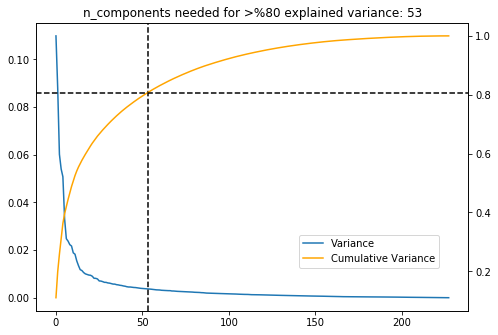

In [42]:
# Find out variance of each principal component.
# Find out top components needed to compute %80 variance:
n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.8)[0]+1)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1],True)
ax2 = ax.twinx()
ax.plot(pca.explained_variance_ratio_, label='Variance',)
ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',color = 'orange');
ax.set_title('n_components needed for >%80 explained variance: {}'.format(n_components));
ax.axvline(n_components, linestyle='dashed', color='black')
ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='black')
fig.legend(loc=(0.6,0.2));

In [43]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=n_components, random_state=50)
azdias_pca = pca.fit_transform(azdias_after_scaling_pca)

In [44]:
round((pca.explained_variance_ratio_.sum())*100,4)

80.2198

In [59]:
## Components analysis

def comp_analysis(azdias_after_scaling_pca):
    feature_map = pd.Series(azdias_after_scaling_pca.columns, range(len(azdias_after_scaling_pca.columns)))
    components = {}
    for ix in range(pca.components_.shape[0]):
        components[ix] = [(feature_map[a],b) for a,b in sorted(enumerate(pca.components_[ix]),key=lambda x:x[1],reverse=True)]
    return pd.DataFrame(components)

In [65]:
# Top 10 positive components
components = comp_analysis(azdias_after_scaling_pca)
components[:10]

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,"(LP_STATUS_FEIN, 0.21067395245110926)","(FINANZ_SPARER, 0.19598768869230798)","(KBA13_BAUMAX, 0.1934045224949617)","(KBA13_SITZE_5, 0.19093184822285944)","(ANREDE_KZ, 0.45536418882503)","(KOMBIALTER, 0.24411941934835946)","(KBA13_KW_61_120, 0.1713881933390508)","(KBA13_ALTERHALTER_45, 0.1888310497332497)","(KBA13_ALTERHALTER_61, 0.19217871893466595)","(LP_FAMILIE_FEIN, 0.281279475102393)",...,"(VK_ZG11, 0.14877074182553932)","(KBA13_CCM_1600, 0.49430141733159627)","(KBA13_BAUMAX, 0.1730057434355983)","(BALLRAUM, 0.17963816739458535)","(KBA13_SEG_UTILITIES, 0.21334146463377962)","(W_KEIT_KIND_HH, 0.3131981473985013)","(ZABEOTYP, 0.2771843458174178)","(ZABEOTYP, 0.2716439884504765)","(KBA13_KMH_251, 0.2677689308498275)","(D19_KONSUMTYP, 0.19979211160009436)"
1,"(LP_STATUS_GROB, 0.2068448103303206)","(CJT_TYP_1, 0.1919919138440617)","(PLZ8_BAUMAX, 0.1822736815748964)","(KBA13_HALTER_25, 0.15725026974789721)","(SEMIO_KAEM, 0.25661520642525315)","(SEMIO_REL, 0.19854487233638526)","(KBA13_KMH_210, 0.16539463235392032)","(KBA13_HALTER_40, 0.16989170093470615)","(KBA13_HALTER_66, 0.1836250289118631)","(LP_FAMILIE_GROB, 0.27132448652743957)",...,"(D19_VERSAND_ONLINE_DATUM, 0.1429188359031523)","(SEMIO_LUST, 0.1859539015085616)","(PLZ8_BAUMAX, 0.16559546970802963)","(FINANZ_VORSORGER, 0.1720753324972202)","(LNR, 0.17862077064798287)","(KBA13_CCM_3001, 0.1907490538887797)","(UMFELD_JUNG, 0.2429256304828508)","(BALLRAUM, 0.25383937387624905)","(KBA13_FORD, 0.2306990084030997)","(KBA13_CCM_3001, 0.17420851880707675)"
2,"(FINANZ_MINIMALIST, 0.19807117488390774)","(PRAEGENDE_JUGENDJAHRE, 0.18890118903988654)","(VERS_TYP, 0.1655416473673857)","(KBA13_SEG_KOMPAKTKLASSE, 0.13610981832969382)","(SEMIO_DOM, 0.21554922824542663)","(STRUKTURTYP, 0.16749547451222332)","(KBA13_VORB_0, 0.16269673451625918)","(KBA13_HALTER_35, 0.14161443719250172)","(KBA13_HALTER_65, 0.1535830837244296)","(LP_LEBENSPHASE_GROB, 0.24072665667310286)",...,"(UMFELD_JUNG, 0.13704440168824422)","(KBA13_KMH_180, 0.15384237393297995)","(KBA13_SEG_MINIWAGEN, 0.15955399082003038)","(KBA13_SEG_UTILITIES, 0.1555203634480311)","(KBA13_SEG_SONSTIGE, 0.16823718263051107)","(VK_ZG11, 0.1699155156234751)","(LNR, 0.22284694531389102)","(KBA05_GBZ, 0.22299530158668293)","(INNENSTADT, 0.20085771788560042)","(KBA13_FIAT, 0.15599403544555474)"
3,"(MOBI_RASTER, 0.1422355829271681)","(ONLINE_AFFINITAET, 0.18888376305249407)","(SEMIO_VERT, 0.16037131803495033)","(SEMIO_KULT, 0.13521211306103703)","(SEMIO_ERL, 0.19798148221430206)","(FINANZ_UNAUFFAELLIGER, 0.1627653587981321)","(KBA13_HALTER_66, 0.13112204226247803)","(KBA05_KRSZUL, 0.13742492076755336)","(FINANZ_HAUSBAUER, 0.1252980012861346)","(LP_LEBENSPHASE_FEIN, 0.22749133153957848)",...,"(RT_SCHNAEPPCHEN, 0.13344352432900425)","(WOHNDAUER_2008, 0.14518362357692147)","(KBA13_CCM_1600, 0.1510958944461249)","(D19_VERSI_DATUM, 0.15048533421774096)","(UMFELD_JUNG, 0.16565091502295742)","(VK_DISTANZ, 0.16512415618252813)","(KBA13_SEG_SONSTIGE, 0.2132678678547741)","(KBA13_TOYOTA, 0.19528694190856632)","(KBA13_RENAULT, 0.14494397920831512)","(KBA13_TOYOTA, 0.1533934611086258)"
4,"(CJT_TYP_3, 0.1421840157633512)","(FINANZ_ANLEGER, 0.1842640117285281)","(HEALTH_TYP, 0.1480655745213238)","(KBA13_ALTERHALTER_30, 0.1341875662325077)","(SEMIO_KRIT, 0.19153193625331102)","(SEMIO_FAM, 0.1477976397578972)","(KBA13_BJ_2006, 0.12686072436526105)","(KBA05_HERST2, 0.13708336175892355)","(HH_EINKOMMEN_SCORE, 0.12086154412398051)","(KBA13_KMH_180, 0.1388157244197461)",...,"(D19_VERSAND_DATUM, 0.1216980254677799)","(KBA13_KW_61_120, 0.14305174848743404)","(D19_KONSUMTYP, 0.14057058088924612)","(D19_KONSUMTYP_MAX, 0.14626893491968262)","(SEMIO_SOZ, 0.13977066215869116)","(KBA13_HERST_EUROPA, 0.1367062999640169)","(SEMIO_KRIT, 0.13029804323866115)","(STRUKTURTYP, 0.1938492957389609)","(KBA13_SEG_SONSTIGE, 0.14416510695466628)","(W_KEIT_KIND_HH, 0.13347856106906442)"
5,"(CJT_TYP_5, 0.1405345391028247)","(CJ

In [66]:
# Top 10 negative components
components[-10:]


,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
218,"(FINANZ_HAUSBAUER, -0.12450562059967304)","(SEMIO_LUST, -0.1413874815489814)","(SEMIO_KRIT, -0.12109325073821657)","(KBA13_BMW, -0.14850282098407913)","(KBA13_HERST_BMW_BENZ, -0.0945722273389148)","(VK_DISTANZ, -0.12119787465528005)","(KBA13_VORB_2, -0.14010335767794818)","(D19_GESAMT_DATUM, -0.07595097765484395)","(LP_STATUS_GROB, -0.17326214566054698)","(GEMEINDETYP, -0.07579444660137838)",...,"(VERS_TYP, -0.11491028838616911)","(KBA13_KMH_251, -0.10555810277299776)","(SEMIO_SOZ, -0.14036622923687764)","(VERS_TYP, -0.13673150357046138)","(KBA13_KRSHERST_BMW_BENZ, -0.12328183436255566)","(SEMIO_MAT, -0.12222783115157648)","(VK_DHT4A, -0.09633941406545685)","(KBA13_AUDI, -0.11175647551166018)","(WOHNDAUER_2008, -0.1218882235149891)","(KBA13_KMH_251, -0.13183052384422195)"
219,"(HH_EINKOMMEN_SCORE, -0.1304889778022464)","(D19_GESAMT_DATUM, -0.14717837462352262)","(ANREDE_KZ, -0.12750471367222374)","(STRUKTURTYP, -0.14853664770390693)","(SEMIO_MAT, -0.1015735044095311)","(VK_DHT4A, -0.12577498371272097)","(KBA13_BJ_1999, -0.15043889791358975)","(D19_VERSAND_ONLINE_DATUM, -0.07743809254112936)","(KBA13_HALTER_30, -0.17731408129476572)","(KBA13_VORB_0, -0.07778042784915315)",...,"(D19_VERSI_DATUM, -0.11850712535550186)","(D19_KONSUMTYP, -0.10986653892660628)","(KBA13_PEUGEOT, -0.14425383766952665)","(D19_VERSAND_ONLINE_DATUM, -0.14163844092559272)","(KBA13_NISSAN, -0.12457694247928842)","(CJT_TYP_3, -0.13798505777179404)","(KBA13_OPEL, -0.09932565318035774)","(ANREDE_KZ, -0.11259594494270422)","(KBA13_PEUGEOT, -0.13922707461443604)","(D19_BANKEN_ONLINE_DATUM, -0.1379540473216039)"
220,"(D19_KONSUMTYP_MAX, -0.13056307723387506)","(D19_GESAMT_ONLINE_DATUM, -0.1479998278556981)","(BALLRAUM, -0.13452131697702818)","(SEMIO_KAEM, -0.15096908012662727)","(RT_SCHNAEPPCHEN, -0.11221984226387839)","(VK_ZG11, -0.12682821984995105)","(KBA13_HALTER_45, -0.1530788307518146)","(D19_VERSAND_DATUM, -0.07835483140936837)","(LP_STATUS_FEIN, -0.17900418062285142)","(KBA13_AUDI, -0.07965187103834295)",...,"(KBA13_SEG_UTILITIES, -0.12971225090089714)","(KBA13_FORD, -0.12867819323070637)","(WOHNDAUER_2008, -0.17912392119018508)","(CJT_GESAMTTYP, -0.1469273834300261)","(KBA13_SEG_KLEINWAGEN, -0.1259228957131135)","(ANREDE_KZ, -0.14929952258250956)","(VK_DISTANZ, -0.10400840681785377)","(KBA13_HALTER_20, -0.11715081884915625)","(WOHNLAGE, -0.14285206495336453)","(D19_BANKEN_DATUM, -0.14885621257139595)"
221,"(CJT_TYP_1, -0.1432340769503534)","(RETOURTYP_BK_S, -0.16095220546810723)","(FINANZ_UNAUFFAELLIGER, -0.15501456900714228)","(KBA13_CCM_3001, -0.15883661068004823)","(SEMIO_REL, -0.144503437646738)","(NATIONALITAET_KZ, -0.1362066759887623)","(KBA13_ALTERHALTER_45, -0.156540114156917)","(D19_GESAMT_ONLINE_DATUM, -0.07917493729306287)","(LP_LEBENSPHASE_FEIN, -0.1877536483339175)","(KBA13_KRSZUL_NEU, -0.08334152627774401)",...,"(SEMIO_KRIT, -0.13077348054945925)","(PLZ8_ANTG2, -0.13440759250188467)","(W_KEIT_KIND_HH, -0.1954451373405547)","(CJT_KATALOGNUTZER, -0.14717673797110056)","(LP_STATUS_GROB, -0.1354979694337743)","(D19_BANKEN_ONLINE_DATUM, -0.1629716990426102)","(MOBI_REGIO, -0.10562219655917114)","(KBA13_FIAT, -0.13678963956530343)","(HH_EINKOMMEN_SCORE, -0.14306776636889632)","(RT_KEIN_ANREIZ, -0.149705273805679)"
222,"(AKT_DAT_KL, -0.145628112437353)","(CJT_TYP_6, -0.1715014495068946)","(D19_VERSAND_ONLINE_DATUM, -0.17442493113923155)","(KBA13_SEG_OBEREMITTELKLASSE, -0.1619049363863...","(OST_WEST_KZ, -0.15359461058871807)","(D19_KONSUMTYP, -0.1584170711368022)","(KBA13_KMH_180, -0.15737224180412915)","(EWDICHTE, -0.08246655503340786)","(LP_LEBENSPHASE_GROB, -0.19433355358955087)","(KBA13_KMH_251, -0.08633728820059398)",...,"(D19_KONSUMTYP_MAX, -0.14932933718197394)","(KBA13_KW_0_60, -0.14610981274896342)","(SEMIO_LUST, -0.21307978613337974)","(CJT_TYP_4, -0.15266744131949753)","(KBA13_KMH_251, -0.1386997677524212)","(STRUKTURTYP, -0.16723548926205992)","(KBA13_SEG_KOMPAKTKLASSE, -0.11

## Using Kmeans for clustering

In [67]:
# Obtain Kmeans sccore
def kmeans_score(df, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        df - the dataset suuplied
        center -  number of centers required (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    # instantiate kmeans
    kmeans = KMeans(n_clusters=center, random_state=50, n_jobs=-1)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(df)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(df))
    
    return score

In [46]:
# Apply the elbow method
score_list = []
centers = np.arange(2, 12)


for center in centers: 
    # Append score to 
    score_list.append(kmeans_score(azdias_pca, center))

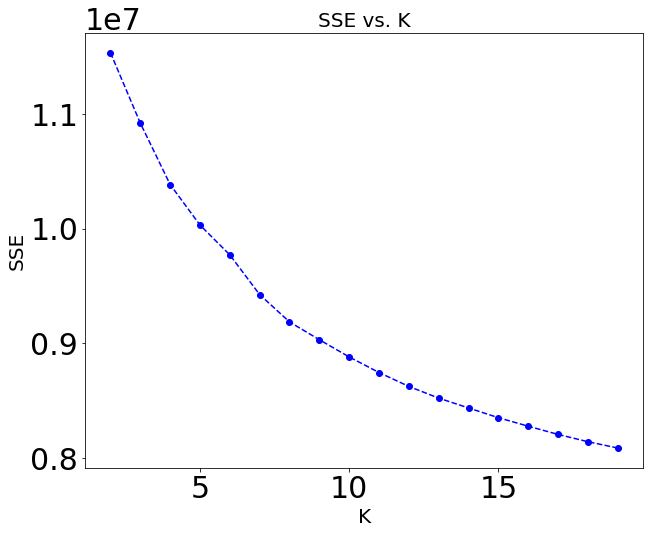

In [57]:
# Investigate the change in within-cluster distance across number of clusters.

plt.figure(figsize=(10, 8)) 
plt.plot(centers, score_list, linestyle='--', marker='o', color='b');
plt.rc('xtick', labelsize=30)  
plt.rc('ytick', labelsize=30)
plt.xlabel('K', fontsize=20)
plt.ylabel('SSE', fontsize=20)
plt.title('SSE vs. K', fontsize=20)
plt.show()

We do not have a clear elbow . But after cluster 6 there is less decrease . Hence chossing 6 cluster to do K-Means clsutering.

In [68]:
# Re-fit the k-means model with 6 class
kmeans = KMeans(n_clusters=6, random_state=42, n_jobs=-1)
labels_azdias = kmeans.fit_predict(azdias_pca) 

In [69]:
class_count = pd.Series(labels_azdias).value_counts()

cls_azdias = pd.DataFrame({'cluster': class_count.index,
                           '% of data': 100*class_count.values/len(labels_azdias)})
cls_azdias['data'] = 'general population'

# print cls_azdias
cls_azdias

,cluster,% of data,data
0,2,21.629203,general population
1,4,20.151904,general population
2,3,17.536952,general population
3,1,16.393240,general population
4,5,13.843817,general population
5,0,10.444884,general population


In [70]:
# Clustering on customer data

customers_pca = pca.transform(customers_after_scaling_pca)
labels_customers = kmeans.predict(customers_pca)

In [71]:
cus_class = pd.Series(labels_customers).value_counts()

cls_customers = pd.DataFrame({'cluster': cus_class.index,
                              '% of data': 100*cus_class.values/len(labels_customers)})
cls_customers['data'] = 'customers data'

# print cls_azdias
cls_customers

,cluster,% of data,data
0,2,32.730157,customers data
1,4,27.058940,customers data
2,0,24.481352,customers data
3,3,13.318410,customers data
4,5,1.288794,customers data
5,1,1.122347,customers data


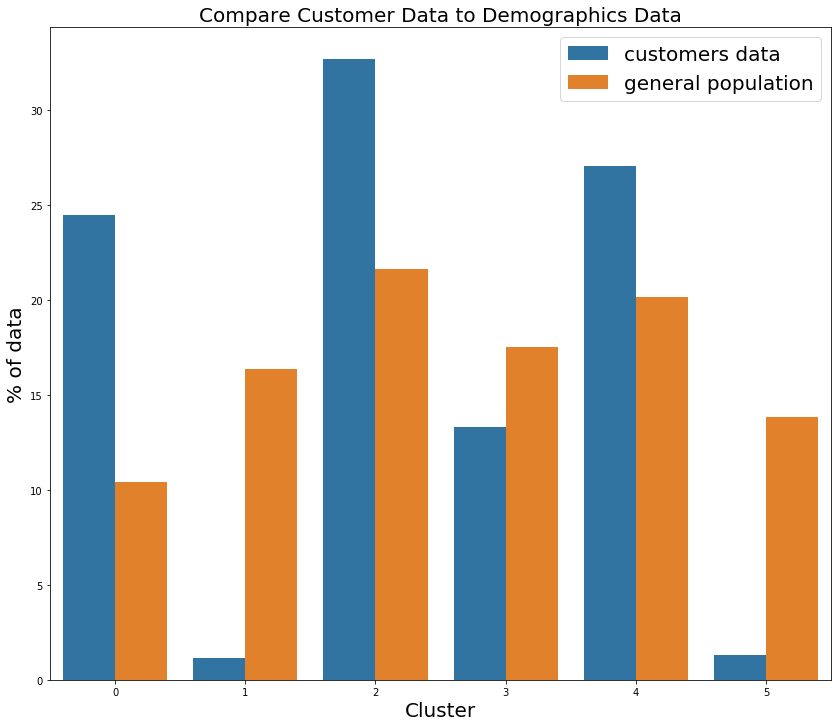

In [75]:
plt.figure(figsize=(14, 12))
sns.barplot(x="cluster", y="% of data", hue="data",
            data=pd.concat([cls_customers, cls_azdias]))
plt.xlabel('Cluster', fontsize=20)
plt.ylabel('% of data', fontsize=20)
plt.title('Compare Customer Data to Demographics Data', fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [ ]:
Population in cluster 2 and 4 are more likely to be customer of mail order company.

In [31]:
'''
### Making similar number of features in customer and azdias and saving it

#diff_cols = azdias_after_scaling.columns - customers_after_scaling.columns 
diff_cols_azdias = []
for i in azdias_after_scaling.columns:
    if i not in customers_after_scaling.columns:
        diff_cols_azdias.append(i)
        
print(len(diff_cols_azdias))        
#diff_cols_azdias

diff_cols_customer = []
for i in customers_after_scaling.columns:
    if i not in azdias_after_scaling.columns:
        diff_cols_customer.append(i)
        
diff_cols_customer

print(customers_after_scaling.columns.shape)
print(azdias_after_scaling.columns.shape)

customers_after_scaling_pca = customers_after_scaling.drop(diff_cols_customer , axis = 1)

azdias_after_scaling_pca = azdias_after_scaling.drop(diff_cols_azdias , axis = 1)

print(customers_after_scaling_pca.shape)
print(azdias_after_scaling_pca.shape)
'''
#azdias_after_scaling_pca.to_csv('azdias_final.csv')
#customers_after_scaling_pca.to_csv('customers_final.csv')

#azdias_after_scaling_pca = pd.read_csv('azdias_final.csv' , index_col=0)
#customers_after_scaling_pca = pd.read_csv('customers_final.csv', index_col=0)


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

### Classification  Models

In [132]:
def fit_classifier(clf, param_grid, X=train_features_scaled, y=train_response):
    """
    Fits a classifier to its training data using GridSearchCV and calculates ROC AUC score
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=0)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(X, y)
    end = time.time()
    time_taken = round(end-start,2)

    print(clf.__class__.__name__)
    print("Time taken : {} secs".format(time_taken))
    print("Best score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    return grid.best_score_, grid.best_estimator_, time_taken

In [133]:
lor = LogisticRegression(random_state=50) # LogisticRegression
rfc = RandomForestClassifier(random_state=50) # RandomForestClassifier
abc = AdaBoostClassifier(random_state=50) # AdaBoostClassifier
gbc = GradientBoostingClassifier(random_state=50) # GradientBoostingClassifier
xgb  = XGBClassifier(random_state=50) #XGBoost
clf_list = [lor, rfc, abc, gbc , xgb]

In [138]:
# Find best classification algorithm
clf_names = []
clf_scores = []
clf_best_ests = []
clf_time_taken = []
clf_dict = {}

for clf in clf_list:
    best_score, best_est, time_taken = fit_classifier(clf, {})
    clf_names.append(clf.__class__.__name__)
    clf_scores.append(best_score)
    clf_best_ests.append(best_est)
    clf_time_taken.append(time_taken)

Training LogisticRegression :
LogisticRegression
Time taken : 18.1 secs
Best score : 0.6553
****************************************
Training RandomForestClassifier :
RandomForestClassifier
Time taken : 6.41 secs
Best score : 0.5269
****************************************
Training AdaBoostClassifier :
AdaBoostClassifier
Time taken : 66.05 secs
Best score : 0.6472
****************************************
Training GradientBoostingClassifier :
GradientBoostingClassifier
Time taken : 180.95 secs
Best score : 0.6724
****************************************
Training XGBClassifier :
XGBClassifier
Time taken : 189.19 secs
Best score : 0.6888
****************************************


In [140]:
# Create clf_df dataframe from clf_dict
clf_dict['best_score'] = clf_scores
clf_dict['time_taken'] = clf_time_taken
clf_dict['best_est'] = clf_best_ests
clf_df = pd.DataFrame(clf_dict, index=clf_names)
clf_df

,best_score,time_taken,best_est
LogisticRegression,0.655308,18.10,"LogisticRegression(C=1.0, class_weight=None, d..."
RandomForestClassifier,0.526929,6.41,"(DecisionTreeClassifier(class_weight=None, cri..."
AdaBoostClassifier,0.647189,66.05,"(DecisionTreeClassifier(class_weight=None, cri..."
GradientBoostingClassifier,0.672359,180.95,([DecisionTreeRegressor(criterion='friedman_ms...
XGBClassifier,0.688834,189.19,"XGBClassifier(base_score=0.5, booster='gbtree'..."


XGBoost has performed the best .It is generally goto model for Kaggle challenges

In [143]:
# Print the best estimator of GradientBoostingClassifier
clf_df.loc['XGBClassifier', 'best_est']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=50,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [144]:
# Print the classes known to the best estimator of XGBoost
clf_df.loc['XGBClassifier', 'best_est'].classes_

array([0, 1], dtype=int64)

In [166]:
### Model Tuning 
param_grid = {#'loss': ['deviance', 'exponential'],
               #'loss': ['exponential'],
              #'learning_rate': [0.01, 0.1, 0.5],
              'learning_rate': [0.05,0.06],
              #'n_estimators': [50, 80, 100,120],
              'n_estimators': [90,100],
              #'max_depth': [2, 3, 4, 6, 8],
              'max_depth': [3,4],
              #'min_samples_split': [2,3,4,5]
              'min_samples_split': [4]
             }


xgb_best_score, xgb_best_est, _ = fit_classifier(xgb, param_grid)
xgb_best_est

Training XGBClassifier :
XGBClassifier
Time taken : 1396.04 secs
Best score : 0.7018
****************************************


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, min_samples_split=4, missing=None,
              n_estimators=90, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=50, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

                         imp_feat
MOBI_RASTER              0.044072
D19_KONSUMTYP_MAX        0.037638
KBA05_ZUL4               0.034319
KBA05_MOD3               0.032314
D19_GESAMT_ONLINE_DATUM  0.032181
FIRMENDICHTE             0.031652
KBA13_KMH_140            0.030944
ANZ_HAUSHALTE_AKTIV      0.030725
LP_LEBENSPHASE_FEIN      0.030494
KBA13_VORB_0             0.030213


Text(0, 0.5, 'Feature Importance Score')

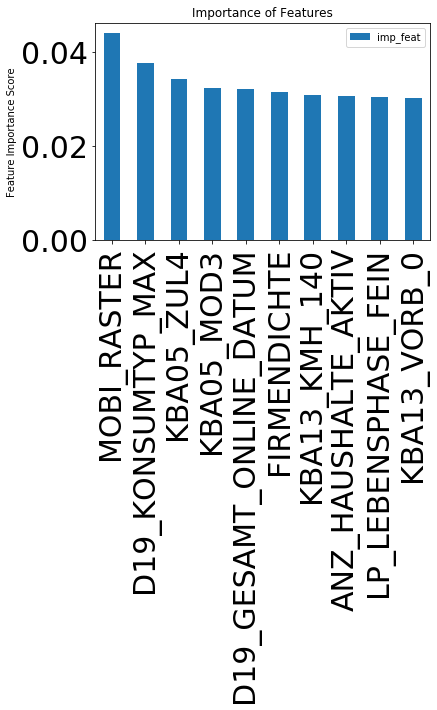

In [169]:
# Print the most important features of the model
imp_feat = pd.DataFrame({'imp_feat':xgb_best_est.feature_importances_}, index=train_features_scaled.columns)
imp_feat_sorted = imp_feat.sort_values(by=['imp_feat'], ascending=False)
print(imp_feat_sorted.head(10))
imp_feat_sorted[:10].plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [171]:
# Predict the class probabilities of the test data using XGBoost  
test_response_proba = xgb_best_est.predict_proba(test_after_scaling)
print(test_response_proba.shape)
test_response_proba

(42833, 2)


array([[0.9756527 , 0.02434732],
       [0.9602157 , 0.0397843 ],
       [0.9922937 , 0.00770631],
       ...,
       [0.97818077, 0.02181926],
       [0.98963094, 0.01036907],
       [0.98147416, 0.01852581]], dtype=float32)

In [172]:
# The array output from predict_proba has columns aligned with classes_
xgb_best_est.classes_

array([0, 1], dtype=int64)

In [173]:
# Create dataframe kaggle_df with two columns

kaggle_data = pd.DataFrame({'LNR': test_LNR, 'RESPONSE': test_response_proba[:, 1]})
kaggle_data.head()

,LNR,RESPONSE
0,1754,0.024347
1,1770,0.039784
2,1465,0.007706
3,1470,0.012475
4,1478,0.015010


In [174]:
# Create CSV file for submitting in Kaggle competition.
kaggle_data.to_csv('kaggle_submission_file.csv', index=False)